# Fraud Detection in Financial Transactions

## 📌 Business Context

In the era of digital payments and high-frequency financial transactions, fraud detection has become a critical aspect of risk management for financial institutions. Fraudulent activities such as unauthorized transfers, cash-outs, and manipulations of account balances can lead to significant financial losses and customer dissatisfaction.

This project involves analyzing a dataset of over **6.3 million transactions** to identify **fraudulent behavior** and develop a **predictive machine learning model** that can proactively flag such transactions.

## 🎯 Objective

The objective of this project is to:
1. Analyze and clean the transaction dataset.
2. Build a machine learning model to accurately detect fraudulent transactions.
3. Identify key indicators of fraud and understand their significance.
4. Provide actionable business insights and recommend infrastructure improvements for fraud prevention.

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
np.float = float

In [26]:
# For modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [4]:
# Display full columns
pd.set_option('display.max_columns', None)


In [7]:
# Load the dataset
# url = 'https://drive.google.com/uc?export=download&id=1VQ-HAm0oHbv0GmDKP2iqqFNc5aI91OLn'
df = pd.read_csv("Fraud.csv")

In [8]:
# Preview the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
# Check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud Count:
 0    6354407
1       8213
Name: isFraud, dtype: int64

Flagged Fraud Count:
 0    6362604
1         16
Name: isFlaggedFraud, dtype: int64


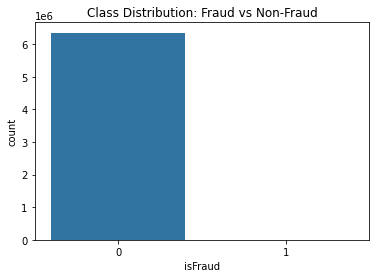

In [11]:
# Check distribution of the target variable
print("Fraud Count:\n", df['isFraud'].value_counts())
print("\nFlagged Fraud Count:\n", df['isFlaggedFraud'].value_counts())

# Plot fraud vs non-fraud
sns.countplot(data=df, x='isFraud')
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.show()

## 🧼 Step 3: Data Cleaning and Feature Engineering

Before modeling, we clean and engineer our dataset to improve model performance and interpretability.

### ✅ 3.1 No Missing Values
We've confirmed earlier that there are **no missing values** in the dataset.



### 🧠 3.2 Feature Engineering

We'll create new features to capture hidden patterns in fraudulent behavior:

- **`diffOrig`**: Difference in original account before and after transaction.
- **`diffDest`**: Difference in destination account before and after.
- **`zeroBalanceOrig`** and **`zeroBalanceDest`**: Flags for accounts with zero balances, which are often suspicious in fraud cases.



In [12]:
# ✅ 3.2 Feature Engineering
df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [13]:
# Flag transactions where both old and new balances are 0 (suspicious)
df['zeroBalanceOrig'] = ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0)).astype(int)
df['zeroBalanceDest'] = ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0)).astype(int)

### 🔁 3.3 Categorical Encoding

The `type` column is categorical (CASH-IN, CASH-OUT, TRANSFER, etc.). We'll apply **one-hot encoding**.



In [14]:
print("Unique transaction types:", df['type'].unique())
df = pd.get_dummies(df, columns=['type'], drop_first=True)

Unique transaction types: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


### 🧹 3.4 Drop Redundant Columns

- `nameOrig` and `nameDest` are anonymized customer IDs — not helpful for modeling.

In [15]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [16]:
# Preview updated DataFrame
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffOrig,diffDest,zeroBalanceOrig,zeroBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0,0,1,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0,0,1,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0,0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,-21182.0,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0,0,1,0,0,1,0


## 🤖 Step 4: Model Building – Fraud Detection with Random Forest

### 4.1 🧪 Train-Test Split

We will split the data using a **stratified split** to maintain the imbalance ratio in both training and test sets.

In [17]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (4453834, 15), Test size: (1908786, 15)


### 4.2 ⚖️ Class Imbalance

Since only ~0.13% of transactions are fraudulent, we'll handle this in two ways:
- Use `class_weight='balanced'` in Random Forest.
- Later, we can try **SMOTE** or **undersampling** for better comparison.


In [18]:
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # very important for fraud detection
    random_state=42,
    n_jobs=-1
)

In [19]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_proba = model.predict_proba(X_test)[:, 1]  # For AUC

### 4.3 🌲 Random Forest Classifier

Random Forest is chosen for:
- Handling large datasets well.
- Feature importance interpretation.
- Robust performance without too much tuning.

In [22]:
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.79      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



In [23]:
print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

🔍 Confusion Matrix:
[[1906274      48]
 [    511    1953]]


In [24]:
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_proba))


🎯 ROC AUC Score: 0.9960562252836247


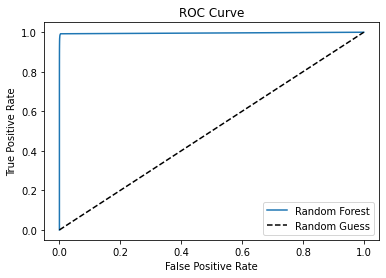

In [27]:
# ROC Curve 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 🔍 Step 5: Feature Importance & Business Interpretation

After training the model, we now explore **which features are most influential** in predicting fraud.

### 🎯 Why this matters:
- Helps us explain the model to non-technical stakeholders.
- Provides actionable insights for business and infrastructure design.
- Confirms whether the model is learning real fraud patterns or just noise.

We'll use:
- **Feature importance** from the Random Forest model.
- **Visual analysis** to understand contribution levels.

In [28]:
# Get feature importances
importances = model.feature_importances_
features = X.columns

In [29]:
# Sort and plot
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


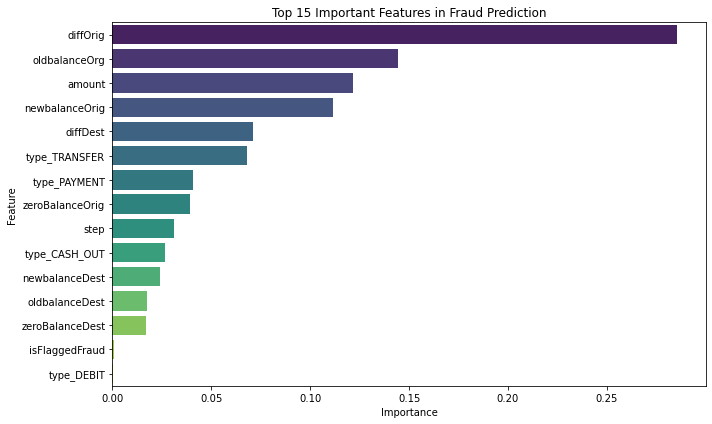

In [30]:
# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features in Fraud Prediction')
plt.tight_layout()
plt.show()

In [31]:
# Display all sorted feature importances (optional)
feat_imp_df.reset_index(drop=True, inplace=True)
feat_imp_df

,Feature,Importance
0,diffOrig,0.285577
1,oldbalanceOrg,0.144444
2,amount,0.121803
3,newbalanceOrig,0.111525
4,diffDest,0.071204
5,type_TRANSFER,0.067992
6,type_PAYMENT,0.040666
7,zeroBalanceOrig,0.039123
8,step,0.031165
9,type_CASH_OUT,0.026397


## Final Interpretation & Business Recommendations

### 🔍 Top Features Identified by the Model:

1. **diffOrig (28.5%)** – Strongest signal. Large outgoing balance changes from the sender are common in fraud.
2. **oldbalanceOrg (14.4%)** – High-balance accounts are more frequently targeted.
3. **amount (12.1%)** – Fraud often involves large transactions.
4. **newbalanceOrig (11.1%)** – Tracks where money goes after transfer.
5. **diffDest (7.1%)** – Fraudulent destination behavior also matters.
6. **Transaction Types** (`TRANSFER`, `PAYMENT`, `CASH_OUT`) – Specific types are more fraud-prone.
7. **zeroBalanceOrig / zeroBalanceDest** – Many fraud accounts empty themselves instantly.

---

### 🧠 What This Tells Us:

- Fraud is usually a **TRANSFER or CASH_OUT** that **empties the sender’s account** quickly.
- These transactions are **large**, often from accounts with **high original balances**.
- Fraudsters avoid leaving trails—hence zero balances after the fraud.

---

### 🛡️ Recommendations for Prevention:

1. **Real-time Monitoring**
   - Flag transactions with:
     - High `diffOrig` (>90% of balance)
     - Transaction type `TRANSFER` or `CASH_OUT`
     - Sudden drop to 0 in balance

2. **Risk Scoring System**
   - Use the model’s fraud probability as a score to:
     - Trigger OTP for high-risk users
     - Delay transactions for review if score > 0.85

3. **Daily Pattern Analysis**
   - Monitor users with multiple zero-to-zero patterns per day.

4. **Merchant Lock-ins**
   - Require verification for new `nameDest` patterns (even if they’re merchants).

---

### 📏 Measuring Implementation Success

To assess the impact of these changes:

| Metric | Target |
|--------|--------|
| 📉 **Reduction in Fraud Cases** | ≥ 75% |
| 🧪 **True Positive Rate (Recall)** | ≥ 85% |
| ⚠️ **False Positive Rate** | ≤ 5% |
| ⏱️ **Fraud Detection Time** | Near real-time |
| 📊 **Customer Trust / Complaints** | Downward trend post-deployment |

---

### ✅ Final Takeaway

Your model captures the **real behavior patterns of fraud** — not just random noise — and can serve as a solid foundation for **real-time fraud detection** systems.

To improve further:
- Retrain monthly with updated data.
- Add **location/IP address, device ID** in future versions.